### Via Data Challenge
Author : James Fung

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np

import math
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from geopandas import GeoDataFrame

from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

pd.options.display.float_format = "{:.6f}".format

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
data = pd.read_csv("/Users/james.fung/Desktop/test_scripts/via/yellow_tripdata_2016-06.csv")
centroids = pd.read_csv("/Users/james.fung/Desktop/test_scripts/via/NHoodNameCentroids.csv")

### Preliminary Feature Extraction

Let's first extract some useful information from tpep_pickup_datetime. Things such as day of the week, day of month, month, and trip duration.

In [3]:
#Create a column for the clean date.
data['clean_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], format= '%Y-%m-%d %H:%M:%S')
data['clean_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], format= '%Y-%m-%d %H:%M:%S')

In [4]:
#Extract day of the week, day of month, and month.
pickup = data['clean_pickup_datetime']
dropoff = data['clean_dropoff_datetime']
data['month'] = pickup.dt.month
data['dom'] = pickup.dt.day
data['dow'] = pickup.dt.dayofweek

#Extract the duration of the trip.
data['diff_sec'] = (dropoff-pickup)/np.timedelta64(1,'s')

In [5]:
#Drop the unecessary columns.
data = data.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1)

In [6]:
#Filter to the first full week of June.
data = data[(data.clean_pickup_datetime >= datetime.datetime(2016,6,6)) & 
        (data.clean_pickup_datetime >= datetime.datetime(2016,6,12)) &
        (data.clean_dropoff_datetime >= datetime.datetime(2016,6,6)) & 
        (data.clean_dropoff_datetime >= datetime.datetime(2016,6,12))]

### Converting Lat/Long Into Meaningful Features

In [7]:
locations = data[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',]]

In [8]:
locations.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,6900536.000000,6900536.000000,6900536.000000,6900536.000000
mean,-73.049594,40.242038,-73.126172,40.285111
std,8.213192,4.524524,7.869322,4.335251
min,-118.186256,0.000000,-118.186256,0.000000
25%,-73.991821,40.736679,-73.991249,40.735050
50%,-73.981461,40.753456,-73.979462,40.754051
75%,-73.966492,40.767883,-73.962143,40.769127
max,0.000000,64.096481,0.000000,60.040714


Select coordinates within NYC.

In [9]:
data = data[
    (data.pickup_longitude >= -74.2563) & (data.pickup_longitude <= -73.6543) &
    (data.pickup_latitude >= 40.4941) & (data.pickup_latitude <= 40.9313) &
    (data.dropoff_longitude >= -74.2563) & (data.dropoff_longitude <= -73.6543) &
    (data.dropoff_latitude >= 40.4941) & (data.dropoff_latitude <= 40.9313)]

In [10]:
centroids['longitude'] = pd.to_numeric(centroids.the_geom.str.replace('POINT ','').str.split(' ').str[0])
centroids['latitude'] = pd.to_numeric(centroids.the_geom.str.replace('POINT ','').str.split(' ').str[1])

In [11]:
# Define a basic Haversine distance formula
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles

In [12]:
def return_boro(latitude, longitude, centroids):
    
    index = haversine(longitude, 
                  latitude, 
                  centroids.longitude, 
                  centroids.latitude).idxmin()
    
    borough = centroids.Name.loc[index]
    
    return borough

In [ ]:
#Apply the above function to all rows - this might take a while!
start = timer()
data['pickup_boro'] = data.parallel_apply(lambda row: 
                                       return_boro(row.pickup_latitude, row.pickup_longitude, centroids), 
                                       axis=1)
data['dropoff_boro'] = data.parallel_apply(lambda row: 
                                       return_boro(row.dropoff_latitude, row.dropoff_longitude, centroids), 
                                       axis=1)
end = timer()
print(end-start)

In [ ]:
#Save the results out to a csv so this does not have to be rerun.
data.to_csv("taxi_june1st_clean.csv")

### Preliminary Data Cleaning

In [13]:
#Read in the data from the last step.
taxi_clean = pd.read_csv("/Users/james.fung/Desktop/test_scripts/via/taxi_june1st_clean.csv")

In [14]:
#Get only the trips within Manhattan.
boros = centroids[['Name', 'Borough']]
taxi_clean = pd.merge(taxi_clean, boros, left_on='pickup_boro', right_on='Name')
taxi_clean = taxi_clean[taxi_clean.Borough == 'Manhattan']

In [15]:
#For some reason the import converted this back.
taxi_clean['clean_pickup_datetime'] = pd.to_datetime(taxi_clean['clean_pickup_datetime'], format= '%Y-%m-%d %H:%M:%S')
taxi_clean['clean_dropoff_datetime'] = pd.to_datetime(taxi_clean['clean_dropoff_datetime'], format= '%Y-%m-%d %H:%M:%S')

#Forgot to do this earlier - we also need minute and hour.
taxi_clean['minute'] = taxi_clean['clean_pickup_datetime'].dt.minute
taxi_clean['hour'] = taxi_clean['clean_pickup_datetime'].dt.hour

In [16]:
#Drop some unecesssary columns.
taxi_clean = taxi_clean.drop(['VendorID',
                                'clean_pickup_datetime',
                                'clean_dropoff_datetime',
                                'Unnamed: 0',
                               'Name'],axis=1)

In [17]:
#Convert some columns into factors.
factors = ['RatecodeID','payment_type','month','dom','dow']
for i in factors:
    taxi_clean[i] = taxi_clean[i].astype(object)

In [18]:
#Check out the numerical columns.
taxi_clean.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,diff_sec,minute,hour
count,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000,6238182.000000
mean,1.655039,2.526673,-73.981904,40.753847,-73.975153,40.753109,11.786115,0.336494,0.497944,1.626934,0.183956,0.299777,14.734769,924.821628,29.572132,13.545007
std,1.302288,28.862374,0.016334,0.021814,0.032866,0.030227,13.671026,0.472947,0.042154,2.251148,1.329503,0.011433,15.112145,3247.238932,17.321626,6.424616
min,0.000000,0.000000,-74.062805,40.688877,-74.256271,40.503670,-150.000000,-4.500000,-0.500000,-46.680000,-12.500000,-0.300000,-150.800000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,-73.992867,40.739731,-73.991623,40.738148,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000,397.000000,15.000000,9.000000
50%,1.000000,1.640000,-73.982742,40.754581,-73.980324,40.755203,9.500000,0.000000,0.500000,1.260000,0.000000,0.300000,11.760000,655.000000,30.000000,14.000000
75%,2.000000,2.860000,-73.971542,40.767311,-73.964973,40.770168,14.000000,0.500000,0.500000,2.300000,0.000000,0.300000,16.800000,1043.000000,45.000000,19.000000
max,9.000000,71732.700000,-73.805153,40.930935,-73.654541,40.931232,20043.770000,597.920000,60.350000,854.850000,554.000000,0.300000,20044.070000,86398.000000,59.000000,23.000000


There are some oddities in this data. Let's do some cleanup.

In [19]:
taxi_clean = taxi_clean[taxi_clean['month']==6]
taxi_clean = taxi_clean[taxi_clean['passenger_count']>0]
taxi_clean = taxi_clean[taxi_clean['fare_amount']>0]
taxi_clean = taxi_clean[taxi_clean['tip_amount']>=0]
taxi_clean = taxi_clean[taxi_clean['diff_sec']>0]

In [20]:
taxi_clean.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,diff_sec,minute,hour
count,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000,6234804.000000
mean,1.654996,2.526988,-73.981903,40.753846,-73.975147,40.753107,11.794359,0.336790,0.498364,1.626972,0.183601,0.299991,14.743648,925.000094,29.572434,13.545683
std,1.302246,28.869667,0.016333,0.021812,0.032859,0.030226,13.656476,0.472741,0.037343,2.240872,1.326277,0.001634,15.095734,3246.471086,17.321659,6.424165
min,1.000000,0.000000,-74.062805,40.688877,-74.256271,40.503670,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,-73.992867,40.739731,-73.991623,40.738148,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000,397.000000,15.000000,9.000000
50%,1.000000,1.640000,-73.982742,40.754581,-73.980324,40.755207,9.500000,0.000000,0.500000,1.260000,0.000000,0.300000,11.760000,655.000000,30.000000,14.000000
75%,2.000000,2.860000,-73.971542,40.767311,-73.964973,40.770172,14.000000,0.500000,0.500000,2.300000,0.000000,0.300000,16.800000,1043.000000,45.000000,19.000000
max,9.000000,71732.700000,-73.805153,40.930935,-73.654541,40.931232,20043.770000,597.920000,60.350000,854.850000,554.000000,0.300000,20044.070000,86398.000000,59.000000,23.000000


Looks a lot better except for the extreme outliers. Let's remove all rows that are greater than the 99th percentile.

In [21]:
#This is a bit lazy coding - sorry!
numerical_cols = taxi_clean.describe().columns
for cols in numerical_cols:
    taxi_clean = taxi_clean[taxi_clean[cols]<=taxi_clean[cols].quantile(q=.99)]

In [22]:
taxi_clean.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,diff_sec,minute,hour
count,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000,5664001.000000
mean,1.652010,1.950035,-73.982429,40.752848,-73.979890,40.753177,10.007955,0.332631,0.499732,1.352433,0.000000,0.299996,12.495932,704.648333,29.602129,13.625471
std,1.300948,1.421757,0.015703,0.020348,0.018601,0.024140,4.790017,0.371068,0.011573,1.324166,0.000000,0.001092,5.493915,419.188096,17.319056,6.398463
min,1.000000,0.000000,-74.053284,40.692238,-74.179436,40.518108,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,1.000000,0.000000,0.000000
25%,1.000000,0.970000,-73.993034,40.739464,-73.992081,40.738941,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.300000,382.000000,15.000000,9.000000
50%,1.000000,1.520000,-73.983070,40.753841,-73.981483,40.754730,9.000000,0.500000,0.500000,1.250000,0.000000,0.300000,11.300000,617.000000,30.000000,14.000000
75%,2.000000,2.500000,-73.972206,40.766350,-73.969048,40.768291,12.500000,0.500000,0.500000,2.150000,0.000000,0.300000,15.350000,946.000000,45.000000,19.000000
max,6.000000,16.400000,-73.945190,40.803062,-73.865150,40.826736,31.500000,1.000000,0.500000,6.450000,0.000000,0.300000,32.160000,2129.000000,59.000000,23.000000


In [23]:
#Any missing values?
taxi_clean.isnull().sum()

passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
month                    0
dom                      0
dow                      0
diff_sec                 0
pickup_boro              0
dropoff_boro             0
Borough                  0
minute                   0
hour                     0
dtype: int64

### Preliminary EDA and Aggregation

One of the first thoughts that comes to mind are single unit passengers who hail a taxi in the same time and same location of another single unit passenger.

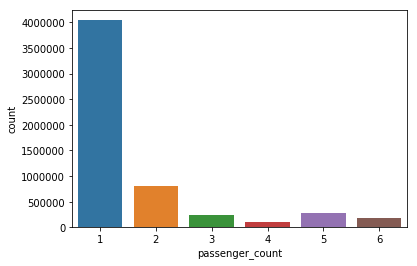

In [24]:
#What is the distribution of passenger counts?
sb.countplot(taxi_clean.passenger_count)

A majority of taxi rides are single passenger rides - suggesting that there could be room for efficiency.

Back to our original solution - let's groupby and count the number of taxis that are in the same five minutes, hour, and pickup and dropoff boro.

With the aggregated data, let's assume:
* If passenger count = 1, the number of rides could be grouped into one ride "i.e. divided by 6."
* If passenger count = 2, the counts could be divded by 3.
* If passenger count = 3, the counts could be divided by 2.
* If passenger count >=4, the ride will be left alone.

Then, round the resulting number up by one to determine the consolidated number of rides.

In [25]:
def regroup(data):
    if data.passenger_count ==1:
        return math.ceil(data.counts/6)
    if data.passenger_count ==2:
        return math.ceil(data.counts/3)
    if data.passenger_count ==3:
        return math.ceil(data.counts/2)
    if data.passenger_count >=4:
        return data.counts
    else:
        return 0

In [26]:
#Round the times so that we can "group" rides within 5 minutes of one another.
taxi_clean['5_minute'] = 5 * round(taxi_clean.minute/5)

In [27]:
agg_5 = taxi_clean.groupby(['5_minute','hour','dow','dom','pickup_boro','dropoff_boro','passenger_count']).size().reset_index()
agg_5 = agg_5.rename(columns={0:'counts'})
agg_5['cat'] = agg_5.parallel_apply(lambda row: regroup(row),axis=1)

Compute the efficiency column for each combination, that is percent reduction in vehicles from taxi to Via.

In [28]:
agg_5['eff'] = (agg_5.counts-agg_5.cat)/agg_5.counts

In [29]:
#What is the overall efficiency?

(sum(agg_5.counts) - sum(agg_5.cat)) / sum(agg_5.counts)

0.36787052120930064

In [30]:
print(sum(agg_5.counts)) #raw number of rides
print(sum(agg_5.cat)) #consolidated number of rides
print(sum(agg_5.counts)-sum(agg_5.cat))

5664001
3580382
2083619


Text(0, 0.5, 'Efficiency')

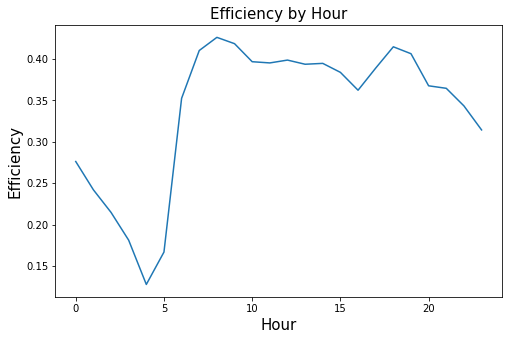

In [41]:
#How does efficiency vary by time?
avg = agg_5[['hour','counts','cat']].groupby('hour').sum()
avg['eff'] = (avg.counts - avg.cat) / avg.counts

plt.figure(figsize=(8,5))
a = sb.lineplot(x=avg.index,y=avg.eff)

a.set_title("Efficiency by Hour", fontsize=15)
a.set_xlabel("Hour",fontsize=15)
a.set_ylabel("Efficiency",fontsize=15)

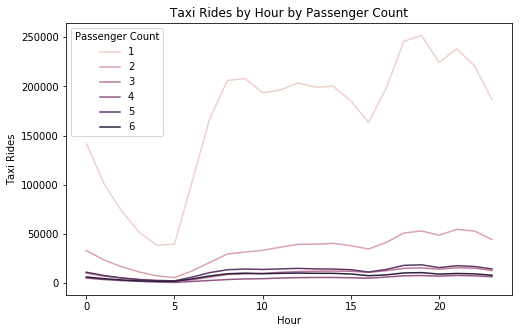

In [32]:
#How many rides are there per hour?
plt.figure(figsize=(8,5))
avg_counts = agg_5[['hour','passenger_count','counts']].groupby(['hour','passenger_count']).sum().reset_index()

ridescount = sb.lineplot(x=avg_counts.hour, y=avg_counts.counts, hue = avg_counts.passenger_count)
ridescount.set_title("Taxi Rides by Hour by Passenger Count")
ridescount.set_xlabel("Hour")
ridescount.set_ylabel("Taxi Rides")
plt.legend(title='Passenger Count', loc='upper left', labels=['1', '2','3','4','5','6'])

### Efficiency with Location

In [33]:
#How does efficiency vary by location?
avg_loc = agg_5[['pickup_boro','counts','cat']].groupby('pickup_boro').sum()
avg_loc['eff'] = (avg_loc.counts - avg_loc.cat) / avg_loc.counts
avg_loc.sort_values(by='eff',ascending=False)

,counts,cat,eff
pickup_boro,,,
Midtown South,499629,264435,0.470737
Murray Hill,412066,222782,0.459354
Lincoln Square,322629,177999,0.448286
Midtown,371696,208739,0.438415
Upper West Side,267160,150348,0.437236
Carnegie Hill,241971,140196,0.420608
Flatiron,337439,196249,0.418416
Tudor City,300581,175577,0.415875
Clinton,284450,167606,0.410772


In [34]:
directory = '/Users/james.fung/Desktop/test_scripts/via/shapefiles/neighborhoods/geo_export_27b1a29a-9f6c-49be-8453-6258a1a1181e.shp'
geo = GeoDataFrame.from_file(directory) #read in shape file
geo = geo[geo.borough == 'Manhattan']

In [35]:
test_map = agg_5[['pickup_boro','counts','cat']].groupby('pickup_boro').sum().merge(geo, how='left', left_on='pickup_boro', right_on='name')
test_map['eff'] = (test_map.counts - test_map.cat) / test_map.counts
test_map = test_map[['eff','geometry']]
test_map = GeoDataFrame(test_map)

In [36]:
#To create the polygons.
directory2 = '/Users/james.fung/Desktop/test_scripts/via/shapefiles/NTA map/geo_export_424d2aca-1b21-43a4-ad0a-1aab8fdbfa6d.shp'
geo2 = GeoDataFrame.from_file(directory2) #read in shape file
geo2 = geo2[geo2.boroname == 'Manhattan']
geo2.head(10)
geo2 = GeoDataFrame(geo2[['geometry']])

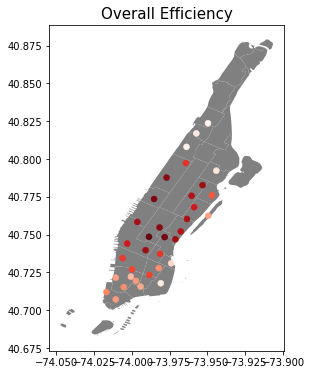

In [37]:
#Plotting the data
fig, ax = plt.subplots(figsize = (6,6))

geo2.plot(alpha=1,linewidth=0.1, ax=ax, color='grey')
test_map.plot(column='eff', cmap='Reds',alpha=1,linewidth=.5, ax=ax)

plt.title('Overall Efficiency', size=15)
plt.show()

What is the efficiency at various times? Let's create buckets for the various activity times.

In [38]:
peak = agg_5[(agg_5.hour >= 6) & (agg_5.hour<=17)][['pickup_boro','counts','cat']].groupby('pickup_boro').sum().merge(geo, how='left', left_on='pickup_boro', right_on='name')
peak['eff'] = (peak.counts - peak.cat) / peak.counts
peak = peak[['eff','geometry']]
peak = GeoDataFrame(peak)

off = agg_5[(agg_5.hour > 0) & (agg_5.hour<5)][['pickup_boro','counts','cat']].groupby('pickup_boro').sum().merge(geo, how='left', left_on='pickup_boro', right_on='name')
off['eff'] = (off.counts - off.cat) / off.counts
off = off[['eff','geometry']]
off = GeoDataFrame(off)

eve = agg_5[(agg_5.hour > 17) & (agg_5.hour<=23)][['pickup_boro','counts','cat']].groupby('pickup_boro').sum().merge(geo, how='left', left_on='pickup_boro', right_on='name')
eve['eff'] = (eve.counts - eve.cat) / eve.counts
eve = eve[['eff','geometry']]
eve = GeoDataFrame(eve)

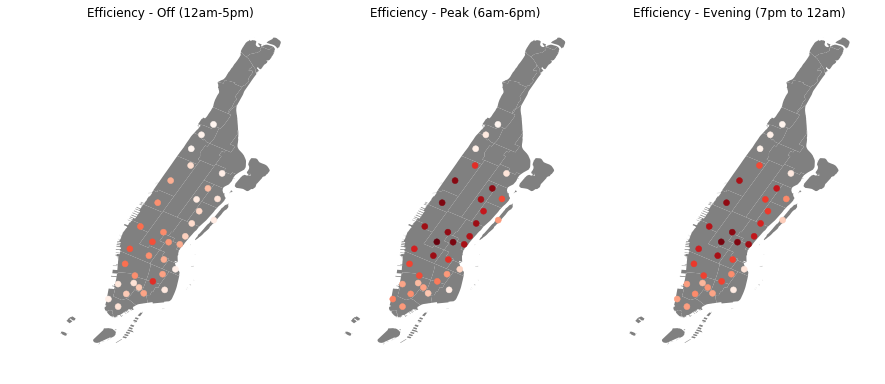

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
plt.tight_layout()

ax1, ax2, ax3 = axes

geo2.plot(alpha=1,linewidth=0.1, ax=ax1, color='grey')
off.plot(column='eff', cmap='Reds',alpha=1,linewidth=.5, ax=ax1, vmin=0, vmax=.50)
ax1.set_title('Efficiency - Off (12am-5pm)', size = 12)
ax1.axis("off")

geo2.plot(alpha=1,linewidth=0.1, ax=ax2, color='grey')
peak.plot(column='eff', cmap='Reds',alpha=1,linewidth=.5, ax=ax2, vmin = 0, vmax=.50)
ax2.set_title('Efficiency - Peak (6am-6pm)', size = 12)
ax2.axis("off")

geo2.plot(alpha=1,linewidth=0.1, ax=ax3, color='grey')
eve.plot(column='eff', cmap='Reds',alpha=1,linewidth=.5, ax=ax3, vmin = 0, vmax=.50)
ax3.set_title('Efficiency - Evening (7pm to 12am)', size=12)
ax3.axis("off")

plt.show()

In [40]:
#Counts of ride from each boro.
agg_5[['pickup_boro','counts']].groupby('pickup_boro').sum().sort_values(by='counts',ascending=False).head(10)

,counts
pickup_boro,
Midtown South,499629
Murray Hill,412066
Midtown,371696
Flatiron,337439
Lincoln Square,322629
Tudor City,300581
Clinton,284450
Upper West Side,267160
Carnegie Hill,241971
